# Stacking Late Fusion model - InceptionV3 + BERT/LSTM

In [1]:
# Install BERT for tf2 module
!pip install bert-for-tf2
# Install Keras version 2.3.1
# !pip install keras==2.9.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 151 kB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-py3-none-any.whl size=30534 sha256=82295f4e26bdac02b90bcc0788e30034250593c00ec125987b7eee254f7f1356
  Stored in directory: /root/.cache/pip/wheels/ab/a4/72/df07592cea3ae06b5e846f5e52262f8b16748e829ca354b7df
  Created wheel for params-flow: filename=params_flow-0.8.2-py3-none-any.whl size=19472 sha256=394d3b6c29afc3f22f5cb402a4cbe5f0983eab23344e845fa157730dd14ecf6c
  Stored in directory: /root/.cache/pip/wheels/c7/f3/85/b8cf1d8bfe55dc2ece0f1fcd4e91d6f8fc7b59ff3fd75329e1
  Created wheel for py-params: filename=py_params-0.10.2-py3-none-any.whl size=7911 sha256=590f1a559782a9cc58e82f81cab1a88df55337aead58d5848b97c5e2d90ad68b
  Stored in directory: /root/.cache/pip/wheels/ac/26/e9/df16869ccbd4abf517f1ff3be9a2c7ee5c5980fc87eea04fb1
Successfully built bert-for-tf2 params-flow p

In [2]:
# Import all necessary libraries
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import utils
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import applications
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.regularizers import l2, l1

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

import bert

import numpy as np 
import pandas as pd
import re
import glob
import os
import cv2
import sys
import pickle

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs
%pwd

/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs


'/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs'

In [ ]:
#Unzip the RGB image folder
# !unzip /content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/RGB.zip

In [ ]:
# !unzip /content/drive/MyDrive/train_titles.csv.zip


In [5]:
# Import the training and test .csv files
colnames=['image_path', 'text', 'food']
train = pd.read_csv('final_full_dataframe.tsv', names=colnames, header=None, sep = '\t', index_col=['image_path'])
#test = pd.read_csv('test_titles.csv', names=colnames, header=None, sep = ',', index_col=['image_path'])

In [6]:
# Sort values by 'image_path'
#test = test.sort_values('image_path')
train = train.sort_values('image_path')

In [7]:
print(train.shape)
train.head()

(16501, 2)


,text,food
image_path,,
allen_wrench_1_1.png,This is a small set of tools.,allen_wrench
allen_wrench_1_1.png,A set of 8 L wrenches. Each wrench is a differ...,allen_wrench
allen_wrench_1_1.png,This is a red object with silver or grey spike...,allen_wrench
allen_wrench_1_1.png,NaN,allen_wrench
allen_wrench_1_1.png,NaN,allen_wrench


In [8]:
print(train.shape)
train.head()

(16501, 2)


,text,food
image_path,,
allen_wrench_1_1.png,This is a small set of tools.,allen_wrench
allen_wrench_1_1.png,A set of 8 L wrenches. Each wrench is a differ...,allen_wrench
allen_wrench_1_1.png,This is a red object with silver or grey spike...,allen_wrench
allen_wrench_1_1.png,NaN,allen_wrench
allen_wrench_1_1.png,NaN,allen_wrench


In [ ]:
# from sklearn.model_selection import train_test_split

# train, test = train_test_split(train, test_size=0.2)

In [9]:

def get_missing(file, df):
  parts = file.split(os.sep)
  idx = parts[-1]
  cls = parts[-2]
  #print("class", cls)
  indexes = df[:,0]
 # print("tect", indexes)
  classes = df[:,2]

  if idx in indexes:
    text = df[idx == indexes][0,1]
    return pd.NA, pd.NA, pd.NA
  else:
    #print("w",cls) #,classes)
    text = df[cls == classes][0,1]
    
  return idx, text, cls   

vec_get_missing = np.vectorize(get_missing, signature='(),(m,n)->(),(),()') 



In [10]:
# Function for images loading

def add_not_found(path, df):
  files = glob.glob(path)
  df = df.reset_index()
  idxs, texts, cls = vec_get_missing(files, df.values)
  
  found = pd.DataFrame({"text": texts,
                        "food": cls,
                       "image_path": idxs})
  na = found.isna().sum().values[0]
  if na<found.shape[0]:
    df = df.append(found)
  df = df.drop_duplicates(subset='image_path', keep='first').dropna()
  df = df.set_index('image_path')
  df = shuffle(df, random_state = 0)
  return df
       

In [ ]:
# Images folders 

#Donot run- removes non duplicates
# train = add_not_found('RGB/*/*.png', train)
# #test = add_not_found('images/test/*/*.jpg', test)

# print("Number of training images:",train.shape[0])
# print("Number of test images:",test.shape[0])



Number of training images: 795


In [11]:
train
train = train.sort_values('image_path')
train

,text,food
image_path,,
allen_wrench_1_1.png,This is a small set of tools.,allen_wrench
allen_wrench_1_1.png,It is a set of hex keys.,allen_wrench
allen_wrench_1_1.png,A small set of allen wrenches in a red container.,allen_wrench
allen_wrench_1_1.png,NaN,allen_wrench
allen_wrench_1_1.png,A set of L shaped hex tools.,allen_wrench
...,...,...
water_bottle_5_4.png,A small bottle of water with a blue label.,water_bottle
water_bottle_5_4.png,"This is a small, plastic water bottle. The lab...",water_bottle
water_bottle_5_4.png,This a bottle of water. The bottle has a blue...,water_bottle


In [12]:
# Import the BERT BASE model from Tensorflow HUB (layer, vocab_file and tokenizer)
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [13]:
# Preprocessing of texts according to BERT +
# Cleaning of the textst

def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(str(sen))
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    sentence = sentence.lower()
    return sentence

def remove_tags(text):
    return TAG_RE.sub('', text)

TAG_RE = re.compile(r'<[^>]+>')
vec_preprocess_text = np.vectorize(preprocess_text)

def get_tokens(text, tokenizer):
  tokens = tokenizer.tokenize(text)
  tokens = ["[CLS]"] + tokens + ["[SEP]"]
  length = len(tokens)
  if length > max_length:
      tokens = tokens[:max_length]
  return tokens, length  

def get_masks(text, tokenizer, max_length):
    """Mask for padding"""
    tokens, length = get_tokens(text, tokenizer)
    return np.asarray([1]*len(tokens) + [0] * (max_length - len(tokens)))
vec_get_masks = np.vectorize(get_masks, signature = '(),(),()->(n)')

def get_segments(text, tokenizer, max_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    tokens, length = get_tokens(text, tokenizer)
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return np.asarray(segments + [0] * (max_length - len(tokens)))
vec_get_segments = np.vectorize(get_segments, signature = '(),(),()->(n)')

def get_ids(text, tokenizer, max_length):
    """Token ids from Tokenizer vocab"""
    tokens, length = get_tokens(text, tokenizer)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_ids = np.asarray(token_ids + [0] * (max_length-length))
    return input_ids
vec_get_ids = np.vectorize(get_ids, signature = '(),(),()->(n)')

def get_texts(path):
    path = path.decode('utf-8')
    parts = path.split(os.sep)
    #print("try",parts)
    image_name = parts[-1]
    #print("testst",image_name)
    is_train = parts[-3] == 'train'
    # print
    # if is_train:
    df = train
    # else:
    #   print("bad")
      #df = test
    
    # if is_train:
    #   df = train
    # else:
    #   df = test

    text = df['text'][image_name]
    #print("test",text)
    return text
vec_get_text = np.vectorize(get_texts)


def prepare_text(paths):
    #Preparing texts
    
    texts = vec_get_text(paths)
    
    text_array = vec_preprocess_text(texts)
    ids = vec_get_ids(text_array, 
                      tokenizer, 
                      max_length).squeeze().astype(np.int32)
    masks = vec_get_masks(text_array,
                          tokenizer,
                          max_length).squeeze().astype(np.int32)
    segments = vec_get_segments(text_array,
                                tokenizer,
                                max_length).squeeze().astype(np.int32)
    
    return ids, segments, masks

def clean(i, tokens):
  try:
    this_token = tokens[i]
    next_token = tokens[i+1]
  except:
    return tokens
  if '##' in next_token:
      tokens.remove(next_token)
      tokens[i] = this_token + next_token[2:]
      tokens = clean(i, tokens)
      return tokens
  else:
    i = i+1
    tokens = clean(i, tokens)
    return tokens

def clean_text(array):
  array = array[(array!=0) & (array != 101) & (array != 102)]
  tokens = tokenizer.convert_ids_to_tokens(array)
  tokens = clean(0, tokens)
  text = ' '.join(tokens)
  return text

In [14]:
# Images preprocessing
def load_image(path):
    path = path.decode('utf-8')
    image = cv2.imread(path)
    image = cv2.resize(image, (img_width, img_height))
    image = image/255
    image = image.astype(np.float32)
    parts = path.split(os.sep)
    labels = parts[-2] == Classes 
    labels = labels.astype(np.int32)
    
    return image, labels
    
vec_load_image = np.vectorize(load_image, signature = '()->(r,c,d),(s)')

In [15]:
# Dataset creation

def prepare_data(paths):
    #Images and labels
    images, labels = tf.numpy_function(vec_load_image, 
                                      [paths], 
                                      [tf.float32, 
                                        tf.int32])
    
    
    [ids, segments, masks, ] = tf.numpy_function(prepare_text, 
                                              [paths], 
                                              [tf.int32, 
                                               tf.int32,
                                               tf.int32])
    images.set_shape([None, img_width, img_height, depth])
    labels.set_shape([None, nClasses])
    ids.set_shape([None, max_length])
    masks.set_shape([None, max_length])
    segments.set_shape([None, max_length])
    return ({"input_word_ids": ids, 
             "input_mask": masks,  
             "segment_ids": segments, 
             "image": images},
            {"class": labels})
    

    return dataset

In [16]:
# Parameters setting: images width and height, depth, number if classes, input shape
batch_size =  80
img_width = 299
img_height = 299
depth = 3
max_length = 20 #Setup according to the text

nClasses = train.food.nunique()
Classes = train.food.unique()
input_shape = (img_width, img_height, depth)

In [18]:
# Images loading using tf.data
def tf_data(path, batch_size):
    paths = tf.data.Dataset.list_files(path)
    paths = paths.batch(64)
    dataset = paths.map(prepare_data, tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    dataset = dataset.unbatch()
    dataset = dataset.batch(batch_size)
    
    dataset = dataset.repeat()
    
    return dataset   
# data_train = tf_data('RGB/*/*.png', batch_size)
data_train = tf_data('/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/RGB_cropped_Train_test_val/train/*/*.png', batch_size)
data_test = tf_data('/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/RGB_cropped_Train_test_val/val/*/*.png', batch_size)
#data_test = tf_data('RGB/*/*.png', batch_size)

In [ ]:
#@title Default title text
data_train

<RepeatDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'segment_ids': TensorSpec(shape=(None, 20), dtype=tf.int32, name=None), 'image': TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None)}, {'class': TensorSpec(shape=(None, 48), dtype=tf.int32, name=None)})>

In [ ]:
# test_dataset = data_train.take(3000) 
# train_dataset = data_train.skip(3000)

In [19]:
ip, op = next(iter(data_train))
images = ip['image'][:16]
input_word_ids = ip['input_word_ids'][:16]
true_labels =  op['class'][:16]

In [20]:
# Print images and related texts before classification
i=1
texts = [clean_text(array) for array in input_word_ids.numpy()]
plt.figure(figsize=(30,30))
for image, label, text in zip(images.numpy(), true_labels.numpy(), texts):
      plt.subplot(4,4,i)
      i+=1
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      plt.imshow(image)
      plt.axis('off')
      plt.title("Text: {}\nCategory: {}".format(text, Classes[label.argmax(0)]))
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [21]:
# Images Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=layers.Input(shape=(299, 299, 3)))
x = base_model.output
x = layers.AveragePooling2D(pool_size=(8, 8))(x)
x = layers.Dropout(.4)(x)
x = layers.Flatten()(x)

predictions = layers.Dense(nClasses,
                    kernel_regularizer=l2(0.005),
                    activity_regularizer=l1(0.005), 
                    activation='softmax')(x)

model_cnn = models.Model(base_model.input, predictions, name='Image_Model')


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
# # Load Images model weights
# Didn't improve when the model weights were included
#model_cnn.load_weights('/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/InceptionV3/weights-improvement-10-0.12.hdf5')

In [22]:
# Freeze the images model layers
for layer in model_cnn.layers:
    layer.trainable = False

In [23]:
# Bert + LSTM model
input_ids = layers.Input(shape=(max_length,), dtype=tf.int32, name='Images')
input_masks = layers.Input(shape=(max_length,), dtype=tf.int32)
input_segments = layers.Input(shape=(max_length,), dtype=tf.int32)
_, seq_out = bert_layer([input_ids, input_masks, input_segments])

X = layers.LSTM(128)(seq_out)
X = layers.Dense(256, activation="relu")(X)
out = layers.Dense(nClasses, activation = 'softmax')(X)
model_lstm = models.Model([input_ids, input_masks, input_segments], out, name='Bert_Model')

In [24]:
# Freeze the Bert + LSTM layers
for layer in model_lstm.layers:
    layer.trainable = False

In [ ]:
# # Load BERT + LSTM model weights
#model_lstm.load_weights('/content/drive/MyDrive/Image-and-Text-fusion-for-UPMC-Food-101-using-BERT-and-CNNs/BERT_LSTM/weights-improvement-14-0.89.hdf

In [25]:
# Multimodal Late Fusion Model
input_word_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = layers.Input(shape=(max_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = layers.Input(shape=(max_length,), dtype=tf.int32,
                                    name="segment_ids")
image_input = layers.Input(shape = input_shape, dtype=tf.float32,
                           name = "image")

image_side = model_cnn(image_input)
text_side = model_lstm([input_word_ids, input_mask, segment_ids])
# Concatenation
merged = layers.Concatenate(name='Concatenation')([image_side, text_side])
merged = layers.Dense(256, activation = 'relu', name='Dense_256')(merged)
merged = layers.Dropout(0.2)(merged)
merged = layers.Dense(128, activation = 'relu', name='Dense_128')(merged)
merged = layers.Dropout(0.2)(merged)
output = layers.Dense(nClasses, activation='softmax', name = "class")(merged)

In [26]:
model = models.Model([input_word_ids, input_mask, segment_ids, image_input], output)

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_word_ids (InputLayer)    [(None, 20)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 20)]         0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 20)]         0           []                           

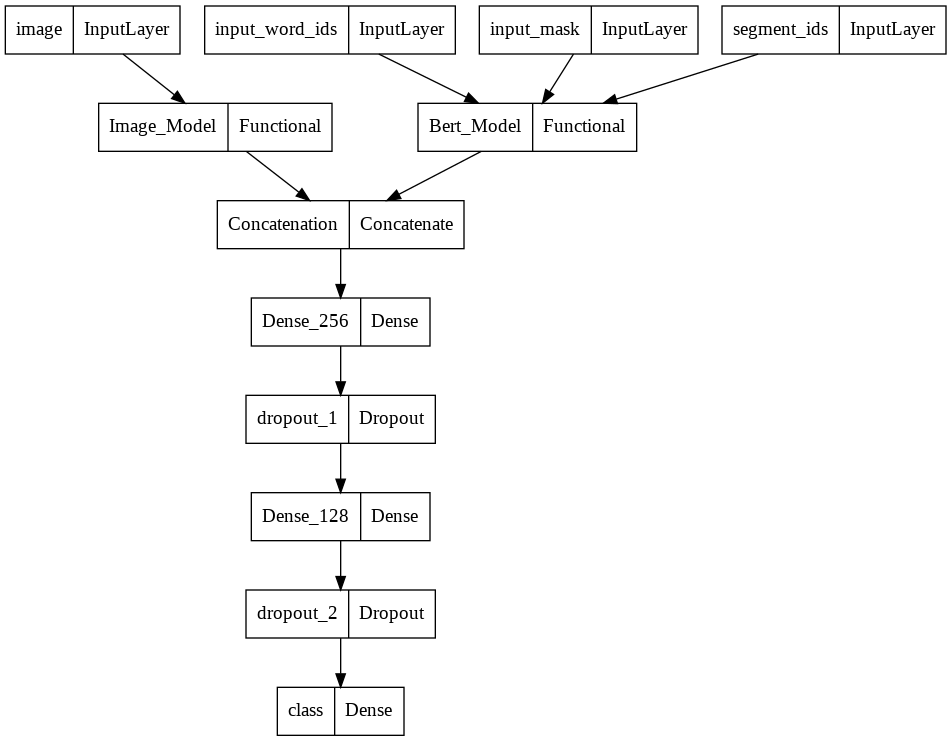

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='multimodal.png')

In [29]:
# Stochastic Gradient Descent optimizer
sgd = optimizers.SGD(learning_rate=0.0001, momentum=0.9, nesterov=False)

# Compile model
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              metrics=['accuracy'])

In [30]:
# Setup callbacks, logs and early stopping condition
checkpoint_path = "stacking_late_fusion/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
cp = callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy',save_best_only=True,verbose=1, mode='max')
csv_logger = callbacks.CSVLogger('stacking_late_fusion/stacking_early.log')
es = callbacks.EarlyStopping(patience = 3, restore_best_weights=True)

In [31]:
# Reduce learning rate if no improvement is observed
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=1, min_lr=0.00001)

In [ ]:
# Load model weights
# model.load_weights('stacking_late_fusion/weights-improvement-02-0.80.hdf5')

In [32]:
train.shape[0]

16501

In [40]:
#Training - no validation dataset , accuracy is poor
history = model.fit(data_train,
                   epochs=15,
                   steps_per_epoch = 500//batch_size,
                   validation_data = data_test,
                   validation_steps = 92//batch_size,
                   callbacks=[csv_logger, reduce_lr])

Epoch 1/15
6/6 [==============================] - 150s 25s/step - loss: 4.3438 - accuracy: 0.0229 - val_loss: 4.3441 - val_accuracy: 0.0135 - lr: 1.0000e-04
Epoch 2/15
6/6 [==============================] - 123s 21s/step - loss: 4.3433 - accuracy: 0.0316 - val_loss: 4.3441 - val_accuracy: 0.0135 - lr: 1.0000e-04
Epoch 3/15
6/6 [==============================] - 119s 20s/step - loss: 4.3436 - accuracy: 0.0267 - val_loss: 4.3440 - val_accuracy: 0.0135 - lr: 1.0000e-05
Epoch 4/15
6/6 [==============================] - 143s 24s/step - loss: 4.3438 - accuracy: 0.0333 - val_loss: 4.3440 - val_accuracy: 0.0135 - lr: 1.0000e-05
Epoch 5/15
6/6 [==============================] - 123s 21s/step - loss: 4.3442 - accuracy: 0.0121 - val_loss: 4.3440 - val_accuracy: 0.0135 - lr: 1.0000e-05
Epoch 6/15
6/6 [==============================] - 120s 20s/step - loss: 4.3438 - accuracy: 0.0194 - val_loss: 4.3440 - val_accuracy: 0.0135 - lr: 1.0000e-05
Epoch 7/15
6/6 [==============================] - 142s 24s

In [ ]:
# Training
#history = model.fit(data_train,
#                    epochs=15,
#                    steps_per_epoch = train.shape[0]//batch_size,
#                    validation_data = data_test,
#                    validation_steps = test.shape[0]//batch_size,
#                    callbacks=[cp, csv_logger, reduce_lr])

In [54]:
# Plot training and test accuracy using Plotly library
df = pd.read_csv('stacking_late_fusion/stacking_early.log')

fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['accuracy'],
                    mode='lines',
                    name='training'))

# fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_accuracy'],
#                     mode='lines',
#                     name='test'))

fig.update_layout(
    font_size = 20,
    xaxis=dict(
        title="Epochs"
    ),
    yaxis=dict(
        title="Accuracy"
))

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [43]:
# Plot training and test loss using Plotly library
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['epoch'], y=df['loss'],
                    mode='lines',
                    name='training'))

# fig.add_trace(go.Scatter(x=df['epoch'], y=df['val_loss'],
#                     mode='lines',
#                     name='test'))

fig.update_layout(
    font_size = 20,
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

fig.update_xaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')
# fig.update_yaxes(showgrid=True, gridwidth=0.5, gridcolor='Gray')

In [45]:
# Model evaluation on test set
# model.evaluate(data_test,
#                steps = test.shape[0]//batch_size)

**Plot some predictions**

In [46]:
# ip, op = next(iter(data_test))
# images = ip['image'][:16]

# input_masks = ip['input_mask'][:16]
# input_word_ids = ip['input_word_ids'][:16]
# input_segments = ip['segment_ids'][:16]

# true_labels =  op['class'][:16]

In [47]:
# pred_labels = model.predict([input_word_ids,
#                              input_masks,
#                              input_segments,
#                              images])

In [55]:
# i=1
# texts = [clean_text(array) for array in input_word_ids.numpy()[:16]]
# plt.figure(figsize=(30,30))
# for image, actual_label, label, text in zip(images.numpy()[:16], true_labels.numpy()[:16], pred_labels, texts):
#       plt.subplot(4,4,i)
#       i+=1
#       image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#       plt.imshow(image)
#       plt.axis('off')
#       plt.title("Text: {}\n Actual: {}\n Predicted: {}".format(text, Classes[actual_label.argmax(0)], Classes[label.argmax(0)]))
#       plt.xlabel(text)
# plt.show()